In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip

import import_ipynb
from My_Functions import null_cols, rmse

importing Jupyter notebook from My_Functions.ipynb


In [2]:
acc_VC_rf = pd.read_csv("acc_VC_rf.csv.gz",
                        compression='gzip',
                        header=0,
                        sep=',',
                        quotechar='"')

acc_VC_gb = pd.read_csv("acc_VC_gb.csv.gz",
                        compression='gzip',
                        header=0,
                        sep=',',
                        quotechar='"')

target_2_train = pd.read_csv("target_2_train_feateng_dwnsmpl.csv.gz",
                                         compression='gzip',
                                         header=0,
                                         sep=',',
                                         quotechar='"')

In [3]:
state=0

xtrain_rf, xtest_rf, ytrain_rf, ytest_rf = ms.train_test_split(acc_VC_rf,
                                                               target_2_train,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_rf = ytrain_rf.values.flatten()


# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [4]:
xtrain_gb, xtest_gb, ytrain_gb, ytest_gb = ms.train_test_split(acc_VC_gb,
                                                               target_2_train,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_gb = ytrain_gb.values.flatten()

## Random Forest Reduced Dataset

In [5]:
xgb_clsfr_rf = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_rf = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_rf = ms.GridSearchCV(xgb_clsfr_rf, gparam_xgb_rf, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_rf.fit(xtrain_rf, ytrain_rf)

# setting up dataframe for results
train_scores.append(gs_xgb_rf.best_estimator_.score(xtrain_rf, ytrain_rf))
test_scores.append(gs_xgb_rf.best_estimator_.score(xtest_rf, ytest_rf))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_rf, ytrain_rf, xtrain_rf))
test_rmse.append(rmse(gs_xgb_rf, ytest_rf, xtest_rf))

# add the best parameters to the df
best_par_list.append(gs_xgb_rf.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_rf, gs_xgb_rf.predict(xtrain_rf)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_rf, gs_xgb_rf.predict(xtest_rf)))

res_df

Wall time: 7.96 s


confusion matrix for train set
[[72083 35627]
 [31484 76294]]


confusion matrix for test set
[[16977  9993]
 [ 8820 18082]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.688563,0.650783,0.558066,0.590946,-0.03288,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [6]:
sorted_importance_rf = sorted(zip(xtrain_rf.columns,
                               gs_xgb_rf.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance_rf

[('grouped_subgrade_12_345', 0.7512546),
 ('ratio_inc_funded', 0.0321746),
 ('int_rate', 0.02940821),
 ('avg_cur_bal', 0.024622481),
 ('emp_length', 0.024314782),
 ('loan_amnt', 0.02352732),
 ('installment', 0.020552795),
 ('dti', 0.020143352),
 ('annual_inc', 0.015707407),
 ('revol_bal', 0.015567939),
 ('duration_of_credit_months', 0.0144804595),
 ('open_acc', 0.014210215),
 ('ratio_redinc_loan', 0.014035801)]

In [7]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_rf, gs_xgb_rf.predict(xtest_rf))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

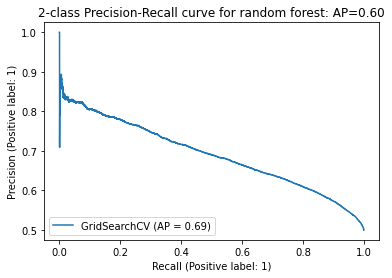

In [8]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_rf, xtest_rf, ytest_rf)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [9]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_rf, gs_xgb_rf.predict(xtest_rf))
recall_score = metrics.recall_score(ytest_rf, gs_xgb_rf.predict(xtest_rf))
precision_score = metrics.precision_score(ytest_rf, gs_xgb_rf.predict(xtest_rf))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.66
recall score: 0.67
precision score: 0.64


In [10]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_rf, gs_xgb_rf.predict(xtest_rf))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6508102659767264

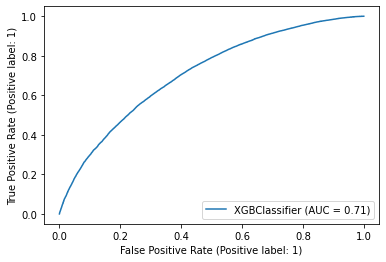

In [11]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_rf.best_estimator_, xtest_rf, ytest_rf) 

In [12]:
filtered_sorted_importance_rf = [x for x in sorted_importance_rf if x[1]>0.003]
filtered_sorted_importance_rf

[('grouped_subgrade_12_345', 0.7512546),
 ('ratio_inc_funded', 0.0321746),
 ('int_rate', 0.02940821),
 ('avg_cur_bal', 0.024622481),
 ('emp_length', 0.024314782),
 ('loan_amnt', 0.02352732),
 ('installment', 0.020552795),
 ('dti', 0.020143352),
 ('annual_inc', 0.015707407),
 ('revol_bal', 0.015567939),
 ('duration_of_credit_months', 0.0144804595),
 ('open_acc', 0.014210215),
 ('ratio_redinc_loan', 0.014035801)]

In [13]:
# get list of column names for easier application in the future
filter_important_rf = []
for tup in filtered_sorted_importance_rf:
    filter_important_rf.append(tup[0])

filter_important_rf

['grouped_subgrade_12_345',
 'ratio_inc_funded',
 'int_rate',
 'avg_cur_bal',
 'emp_length',
 'loan_amnt',
 'installment',
 'dti',
 'annual_inc',
 'revol_bal',
 'duration_of_credit_months',
 'open_acc',
 'ratio_redinc_loan']

# Gradient Boosting Reduced Dataset

In [14]:
xgb_clsfr_gb = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_gb = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_gb = ms.GridSearchCV(xgb_clsfr_gb, gparam_xgb_gb, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_gb.fit(xtrain_gb, ytrain_gb)

# setting up dataframe for results
train_scores.append(gs_xgb_gb.best_estimator_.score(xtrain_gb, ytrain_gb))
test_scores.append(gs_xgb_gb.best_estimator_.score(xtest_gb, ytest_gb))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_gb, ytrain_gb, xtrain_gb))
test_rmse.append(rmse(gs_xgb_gb, ytest_gb, xtest_gb))

# add the best parameters to the df
best_par_list.append(gs_xgb_gb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_gb, gs_xgb_gb.predict(xtrain_gb)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_gb, gs_xgb_gb.predict(xtest_gb)))

res_df

Wall time: 7.47 s


confusion matrix for train set
[[72793 34917]
 [31934 75844]]


confusion matrix for test set
[[17308  9662]
 [ 8885 18017]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.689769,0.655721,0.556984,0.586753,-0.029769,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [15]:
sorted_importance_gb = sorted(zip(xtrain_gb.columns,
                               gs_xgb_gb.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance_gb

[('grouped_subgrade_12_345', 0.6324638),
 ('term', 0.12058718),
 ('home_ownership', 0.051763862),
 ('max_bal_bc', 0.02512579),
 ('int_rate', 0.02491643),
 ('emp_length', 0.022493426),
 ('ratio_inc_funded', 0.021751298),
 ('fico_score', 0.02088241),
 ('dti', 0.019013878),
 ('grade', 0.017798655),
 ('annual_inc', 0.015287232),
 ('revol_bal', 0.014149311),
 ('duration_of_credit_months', 0.013766733)]

In [16]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_gb, gs_xgb_gb.predict(xtest_gb))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

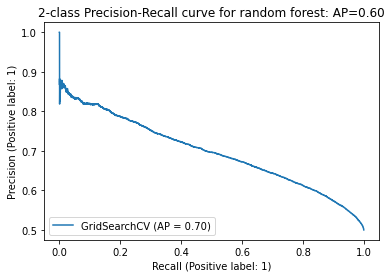

In [17]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_gb, xtest_gb, ytest_gb)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [18]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_gb, gs_xgb_gb.predict(xtest_gb))
recall_score = metrics.recall_score(ytest_gb, gs_xgb_gb.predict(xtest_gb))
precision_score = metrics.precision_score(ytest_gb, gs_xgb_gb.predict(xtest_gb))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.66
recall score: 0.67
precision score: 0.65


In [19]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_gb, gs_xgb_gb.predict(xtest_gb))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6557386252638595

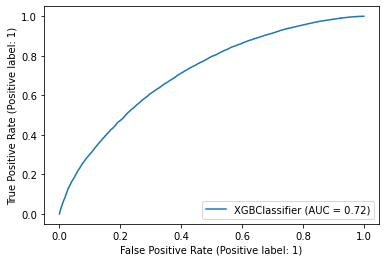

In [20]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_gb.best_estimator_, xtest_gb, ytest_gb) 

In [21]:
filtered_sorted_importance_gb = [x for x in sorted_importance_gb if x[1]>0.003]
filtered_sorted_importance_gb

[('grouped_subgrade_12_345', 0.6324638),
 ('term', 0.12058718),
 ('home_ownership', 0.051763862),
 ('max_bal_bc', 0.02512579),
 ('int_rate', 0.02491643),
 ('emp_length', 0.022493426),
 ('ratio_inc_funded', 0.021751298),
 ('fico_score', 0.02088241),
 ('dti', 0.019013878),
 ('grade', 0.017798655),
 ('annual_inc', 0.015287232),
 ('revol_bal', 0.014149311),
 ('duration_of_credit_months', 0.013766733)]

In [22]:
# get list of column names for easier application in the future
filter_important_gb = []
for tup in filtered_sorted_importance_gb:
    filter_important_gb.append(tup[0])

filter_important_gb

['grouped_subgrade_12_345',
 'term',
 'home_ownership',
 'max_bal_bc',
 'int_rate',
 'emp_length',
 'ratio_inc_funded',
 'fico_score',
 'dti',
 'grade',
 'annual_inc',
 'revol_bal',
 'duration_of_credit_months']